# Per period metrics

# Before preprocessing

In [1]:
!pwd

/home/dritsakon/repos/paper_greekparliament/src


In [2]:
import pandas as pd
import datetime
import nltk
import unicodedata
import matplotlib.pyplot as plt
import re
from numerize import numerize 

print('Reading file...')
df = pd.read_csv('../out_files/tell_all_corrected.csv')
df = df[df['speech'].notna()]

print(df.tail(2))

Reading file...
                        member_name sitting_date parliamentary_period  \
99998  κρητικος νικολαου παναγιωτης   24/01/1992             period 7   
99999   τσιπλακος ιωαννη αριστειδης   24/01/1992             period 7   

      parliamentary_session parliamentary_sitting  \
99998             session 2            sitting 64   
99999             session 2            sitting 64   

                      political_party  \
99998  πανελληνιο σοσιαλιστικο κινημα   
99999                  νεα δημοκρατια   

                                              government member_region  \
99998  ['μητσοτακη κωνσταντινου(11/04/1990-13/10/1993)']   β' πειραιως   
99999  ['μητσοτακη κωνσταντινου(11/04/1990-13/10/1993)']      βοιωτιας   

                                                   roles member_gender  \
99998   ['δ αντιπροεδρος βουλης(22/04/1990-22/10/1993)']          male   
99999  ['υφυπουργος εθνικης οικονομιας(04/11/1990-13/...          male   

                        speaker_in

In [3]:
print(df.speech.iloc[0])

 Παρακαλείται ο Γραμματέας κ. Βουλγαράκης να συνοδεύσει το Μακαριότατο Αρχιεπίσκοπο Αθηνών και πάσης Ελλάδος κ. ΣΕΡΑΦΕΙΜ και τα συνοδεύοντα αυτόν μέλη της Ιεράς Συνόδου κατά την είσοδό τους στην Αίθουσα της Βουλής, προκειμένου να τελεσθεί αγιασμός.  . Στη συνέχεια τελείται ο καθιερωμένος αγιασμός.


In [4]:
from tqdm import tqdm
tqdm.pandas()

df = df.rename(columns={'parliamentary_period': 'period'})

df.period = df.period.apply(lambda x: x.replace(' review 9',''))
df.period = df.period.apply(lambda x: x.replace('period ',''))

df.period = df.period.astype(int)

print(datetime.datetime.now())

#Group speeches by period
PERperiod_df_original = df.groupby(df.period)['speech'].progress_apply(' '.join).reset_index()

print(datetime.datetime.now())

  0%|          | 0/3 [00:00<?, ?it/s]

2021-06-22 02:57:10.204902


100%|██████████| 3/3 [00:00<00:00, 10.35it/s]

2021-06-22 02:57:10.500740


In [5]:
# print(PERperiod_df_original.speech.iloc[0])
print(PERperiod_df_original.columns)

Index(['period', 'speech'], dtype='object')


In [6]:
PERperiod_df_original["size_chars"] = PERperiod_df_original.speech.progress_apply(len)
PERperiod_df_original["size_tokens"] = PERperiod_df_original.speech.progress_apply(lambda x: len(nltk.word_tokenize(x.lower())))
PERperiod_df_original["size_unique_tokens"] = PERperiod_df_original.speech.progress_apply(lambda x: len(set(nltk.word_tokenize(x.lower()))))
PERperiod_df_original["size_sent"] = PERperiod_df_original.speech.progress_apply(lambda x: len(nltk.sent_tokenize(x)))
PERperiod_df_original["size_unique_sent"] = PERperiod_df_original.speech.progress_apply(lambda x: len(set(nltk.sent_tokenize(x.lower()))))

100%|██████████| 3/3 [00:36<00:00, 12.13s/it]


In [7]:
def periods_to_dates(periods):

    period_dict = {5:'7/1989-10/1989',
                  6:'11/1989-3/1990',
                  7:'4/1990-9/1993',
                  8:'10/1993-8/1996',
                  9:'10/1996-3/2000',
                  10:'4/2000-2/2004',
                  11:'3/2004-8/2007',
                  12:'9/2007-9/2009',
                  13:'10/2009-4/2012',
                  14:'5/2012-5/2012', 
                  15:'6/2012-12/2014', 
                  16:'2/2015-8/2015',
                  17:'10/2015-6/2019', 
                  18:'7/2019-7/2020'}
    
    if isinstance(periods, list):
        out = period_dict[periods[0]]+' & '+period_dict[periods[1]]
        return out 
    else:
        return 'Period '+str(periods)+'\n'+period_dict[periods]        

def step_one_pairs(list_of_items):
    return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]


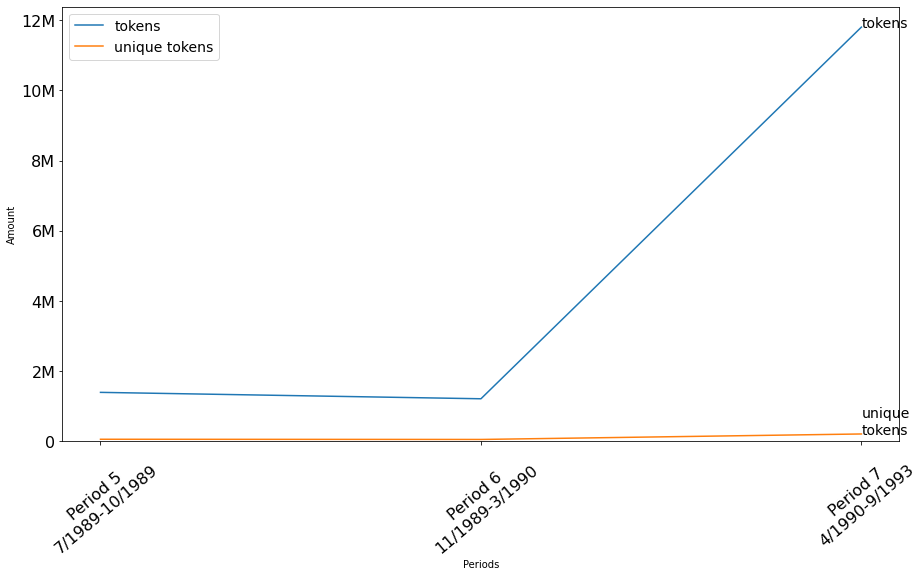

In [8]:
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(15, 8))
plt.ticklabel_format(style = 'plain')


periods = PERperiod_df_original.period.to_list()

# plt.plot(PERperiod_df_original.period,PERperiod_df_original.size_chars)
# plt.annotate(text='characters', xy=(periods[-1],PERperiod_df_original.size_chars.to_list()[-1]), size=14)

plt.plot(PERperiod_df_original.period,PERperiod_df_original.size_tokens)
plt.annotate(text='tokens', xy=(periods[-1],PERperiod_df_original.size_tokens.to_list()[-1]), size=14)

plt.plot(PERperiod_df_original.period,PERperiod_df_original.size_unique_tokens)
plt.annotate(text='unique\ntokens', xy=(periods[-1],PERperiod_df_original.size_unique_tokens.to_list()[-1]), size=14)


x_labels = [periods_to_dates(period) for period in periods]    
plt.xticks(periods,x_labels, rotation=40)

ax = plt.gca()
formatter = FuncFormatter(numerize.numerize)
ax.yaxis.set_major_formatter(formatter)
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)
ax.legend(['tokens', 'unique tokens'], loc='upper left',prop={'size': 14})

plt.ylabel('Amount')
plt.xlabel('Periods')
plt.gca().set_ylim(bottom=0)
plt.rcParams['axes.labelsize'] = 19

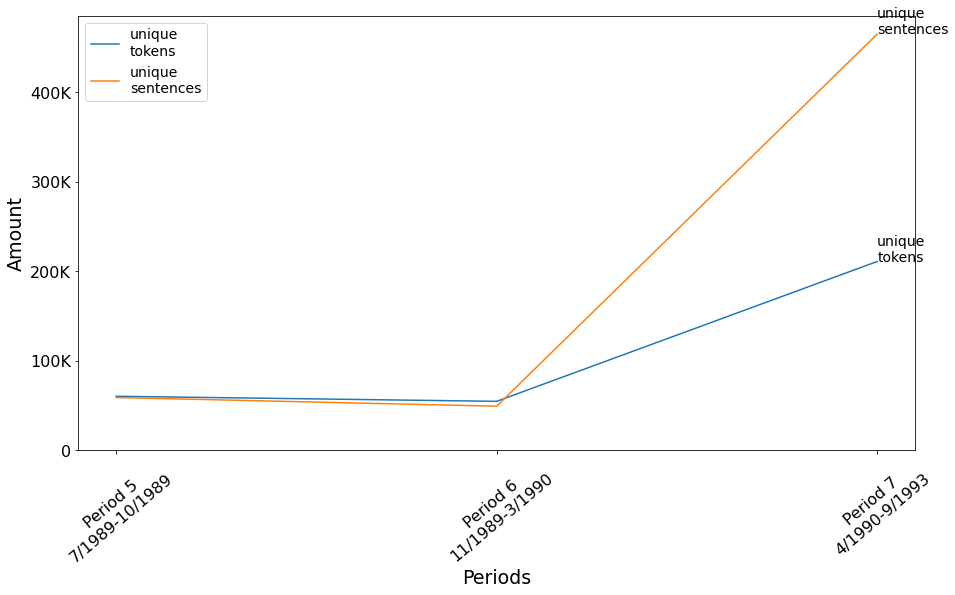

In [9]:
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(15, 8))
plt.ticklabel_format(style = 'plain')

periods = PERperiod_df_original.period.to_list()

plt.plot(PERperiod_df_original.period,PERperiod_df_original.size_unique_tokens)
plt.annotate(text='unique\ntokens', xy=(periods[-1],PERperiod_df_original.size_unique_tokens.to_list()[-1]), size=14)

# plt.plot(PERperiod_df_original.period,PERperiod_df_original.size_sent)
# plt.annotate(text='sentences', xy=(periods[-1],PERperiod_df_original.size_sent.to_list()[-1]), size=14)

plt.plot(PERperiod_df_original.period,PERperiod_df_original.size_unique_sent)
plt.annotate(text='unique\nsentences', xy=(periods[-1],PERperiod_df_original.size_unique_sent.to_list()[-1]), size=14)

x_labels = [periods_to_dates(period) for period in periods]    
plt.xticks(periods,x_labels, rotation=40)

ax = plt.gca()
formatter = FuncFormatter(numerize.numerize)
ax.yaxis.set_major_formatter(formatter)
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)
ax.legend(['unique\ntokens', 'unique\nsentences'], loc='upper left',prop={'size': 14})

plt.ylabel('Amount')
plt.xlabel('Periods')
plt.gca().set_ylim(bottom=0)
plt.rcParams['axes.labelsize'] = 19

In [10]:
# test_df = PERperiod_df_original.copy()
# del test_df['speech']
# del test_df['vocab']
# del test_df['period']

# # del test_df['size_chars']
# # del test_df['size_tokens']

# print(test_df.columns)

In [11]:
# def plot_boxplot(dataframe):
#     plt.rcParams['axes.titlesize'] = 39
#     g = sns.FacetGrid(dataframe, height=10, aspect=0.8)
#     plt.rcParams['axes.labelsize'] = 19
#     plt.rcParams['figure.titlesize'] = 19

#     g.map_dataframe(sns.boxplot)

# plot_boxplot(test_df)


### Common vocabulary size per period

In [12]:
# Sort periods based on number in the string

periods = sorted(PERperiod_df_original.period.to_list())
period_pairs = step_one_pairs(periods)
print(period_pairs)

[(5, 6), (6, 7)]


In [13]:
PERperiod_df_original['vocab'] = PERperiod_df_original.speech.progress_apply(lambda x: nltk.word_tokenize(x.lower()))

100%|██████████| 3/3 [02:25<00:00, 48.57s/it]


In order to compute the commmon vocabulary between each consecutive pair of parliamentary periods, we tokenized the text of each period into a list of words and computed the intersection between each two lists. 

In [14]:
common_vocab = []

for pair in period_pairs:
    
    s1 = set(PERperiod_df_original.loc[(PERperiod_df_original.period==pair[0])].vocab.values[0])
    s2 = set(PERperiod_df_original.loc[(PERperiod_df_original.period==pair[1])].vocab.values[0])
    common_voc = len(s1.intersection(s2))
    common_vocab.append([pair, common_voc])
    
common_vocab_original = pd.DataFrame(common_vocab, columns = ['pair', 'common_vocab'])
print(common_vocab_original.head(2))

     pair  common_vocab
0  (5, 6)         30043
1  (6, 7)         44311


[5, 6, 7]
[(5, 6), (6, 7)]
[5.5, 6.5]


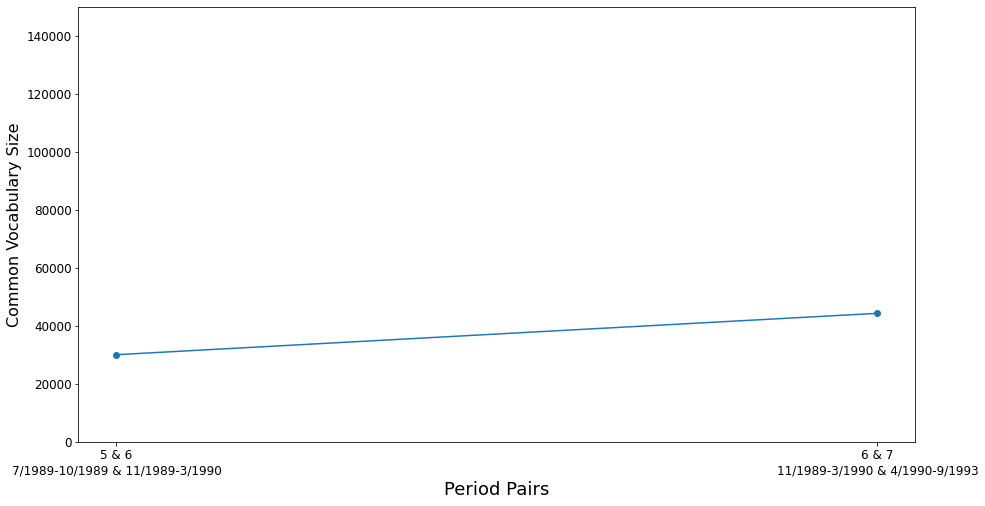

<Figure size 432x288 with 0 Axes>

In [15]:
from matplotlib.font_manager import FontProperties
import random
import matplotlib.pyplot as plt
import seaborn as sns


periods = sorted(PERperiod_df_original.period.to_list())
print(periods)

period_pairs = step_one_pairs(periods)
print(period_pairs)

fig = plt.figure(figsize=(15, 8))
colors = sns.color_palette("hls", 90) #90 is available pairs

plt.rcParams.update({'font.size': 12})

X = common_vocab_original.pair.to_list()
Y = common_vocab_original.common_vocab.to_list()
X = [i+0.5 for i in range(periods[0], periods[-1])]
print(X)
plt.scatter(X,Y)

plt.plot(X,Y)
plt.xticks([i+0.5 for i in range(periods[0], periods[-1])], [
    (str(i)+' & '+str(i+1)+'\n'+periods_to_dates([i,i+1])) for i in range(periods[0], periods[-1])])

plt.xlabel('Period Pairs', fontsize=18)
plt.ylabel('Common Vocabulary Size', fontsize=16)

ax = plt.gca()
ax.set_ylim([0,150000])
handles, labels = ax.get_legend_handles_labels()
plt.savefig('../out_files/common_periodic_vocab_before_test.png', dpi=200,  bbox_inches='tight')

plt.show()
plt.cla()
plt.clf()
fig.clear()
plt.close(fig)


# After preprocessing

In [16]:
import pandas as pd
import datetime
import nltk
import unicodedata
import matplotlib.pyplot as plt
print('Reading file...')
df_cleaned = pd.read_csv('../out_files/tell_all_cleaned.csv', nrows=100000) #, nrows=30000
df_cleaned = df_cleaned[df_cleaned['speech'].notna()]

print(df_cleaned.head(2))

Reading file...
                    member_name sitting_date parliamentary_period  \
0  κρητικος νικολαου παναγιωτης   03/07/1989             period 5   
1  κρητικος νικολαου παναγιωτης   03/07/1989             period 5   

  parliamentary_session parliamentary_sitting                 political_party  \
0             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   
1             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   

                                     government member_region  \
0  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   
1  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   

                                              roles member_gender  \
0  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   
1  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   

  speaker_info                                             speech  
0   προεδρευων  παρακαλειται @sw γραμματεας βουλγαρακης @sw 

In [17]:
test = df_cleaned.speech.iloc[0]
print(test)
print(nltk.word_tokenize(test))
print('------')
print(nltk.sent_tokenize(test))

παρακαλειται @sw γραμματεας βουλγαρακης @sw συνοδευσει @sw μακαριοτατο αρχιεπισκοπο αθηνων @sw πασης ελλαδος σεραφειμ @sw @sw συνοδευοντα @sw μελη @sw ιερας συνοδου @sw @sw εισοδο @sw @sw αιθουσα @sw βουλης @sw @sw τελεσθει αγιασμος.@sw συνεχεια τελειται @sw καθιερωμενος αγιασμος
['παρακαλειται', '@', 'sw', 'γραμματεας', 'βουλγαρακης', '@', 'sw', 'συνοδευσει', '@', 'sw', 'μακαριοτατο', 'αρχιεπισκοπο', 'αθηνων', '@', 'sw', 'πασης', 'ελλαδος', 'σεραφειμ', '@', 'sw', '@', 'sw', 'συνοδευοντα', '@', 'sw', 'μελη', '@', 'sw', 'ιερας', 'συνοδου', '@', 'sw', '@', 'sw', 'εισοδο', '@', 'sw', '@', 'sw', 'αιθουσα', '@', 'sw', 'βουλης', '@', 'sw', '@', 'sw', 'τελεσθει', 'αγιασμος', '.', '@', 'sw', 'συνεχεια', 'τελειται', '@', 'sw', 'καθιερωμενος', 'αγιασμος']
------
['παρακαλειται @sw γραμματεας βουλγαρακης @sw συνοδευσει @sw μακαριοτατο αρχιεπισκοπο αθηνων @sw πασης ελλαδος σεραφειμ @sw @sw συνοδευοντα @sw μελη @sw ιερας συνοδου @sw @sw εισοδο @sw @sw αιθουσα @sw βουλης @sw @sw τελεσθει αγιασμος.',

In [18]:
df_cleaned = df_cleaned.rename(columns={'parliamentary_period': 'period'})

df_cleaned.period = df_cleaned.period.apply(lambda x: x.replace(' review 9',''))
df_cleaned.period = df_cleaned.period.apply(lambda x: x.replace('period ',''))

df_cleaned.period = df_cleaned.period.astype(int)

print(datetime.datetime.now())
#Group speeches by year

PERperiod_df_cleaned = df_cleaned.groupby(df_cleaned.period)['speech'].progress_apply('. '.join).reset_index() #concat sentences, each last sentence for each speech did not have dot so add one.

print(datetime.datetime.now())

  0%|          | 0/3 [00:00<?, ?it/s]

2021-06-22 03:05:48.071118


100%|██████████| 3/3 [00:00<00:00, 11.75it/s]

2021-06-22 03:05:48.332628


In [19]:
# print(PERperiod_df_cleaned.speech.iloc[0])
print(PERperiod_df_cleaned.columns)

Index(['period', 'speech'], dtype='object')


In [20]:
PERperiod_df_cleaned["size_chars"] = PERperiod_df_cleaned.speech.progress_apply(len)
PERperiod_df_cleaned["size_tokens"] = PERperiod_df_cleaned.speech.progress_apply(lambda x: len(nltk.word_tokenize(x)))
PERperiod_df_cleaned["size_unique_tokens"] = PERperiod_df_cleaned.speech.progress_apply(lambda x: len(set(nltk.word_tokenize(x))))
PERperiod_df_cleaned["size_sent"] = PERperiod_df_cleaned.speech.progress_apply(lambda x: len(nltk.sent_tokenize(x)))
PERperiod_df_cleaned["size_unique_sent"] = PERperiod_df_cleaned.speech.progress_apply(lambda x: len(set(nltk.sent_tokenize(x))))


100%|██████████| 3/3 [00:26<00:00,  8.75s/it]


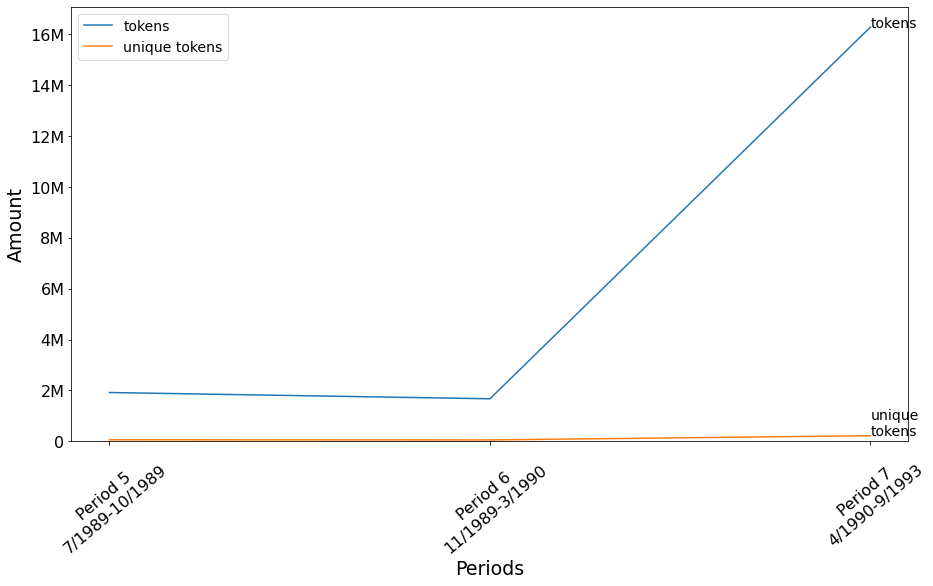

In [21]:
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(15, 8))
plt.ticklabel_format(style = 'plain')


periods = PERperiod_df_cleaned.period.to_list()

# plt.plot(PERperiod_df_cleaned.period,PERperiod_df_cleaned.size_chars)
# plt.annotate(text='characters', xy=(periods[-1],PERperiod_df_cleaned.size_chars.to_list()[-1]), size=14)

plt.plot(PERperiod_df_cleaned.period,PERperiod_df_cleaned.size_tokens)
plt.annotate(text='tokens', xy=(periods[-1],PERperiod_df_cleaned.size_tokens.to_list()[-1]), size=14)

plt.plot(PERperiod_df_cleaned.period,PERperiod_df_cleaned.size_unique_tokens)
plt.annotate(text='unique\ntokens', xy=(periods[-1],PERperiod_df_cleaned.size_unique_tokens.to_list()[-1]), size=14)

x_labels = [periods_to_dates(period) for period in periods]    
plt.xticks(periods,x_labels, rotation=40)

ax = plt.gca()
formatter = FuncFormatter(numerize.numerize)
ax.yaxis.set_major_formatter(formatter)
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)
ax.legend(['tokens', 'unique tokens'], loc='upper left',prop={'size': 14})

plt.ylabel('Amount')
plt.xlabel('Periods')
plt.gca().set_ylim(bottom=0)
plt.rcParams['axes.labelsize'] = 19

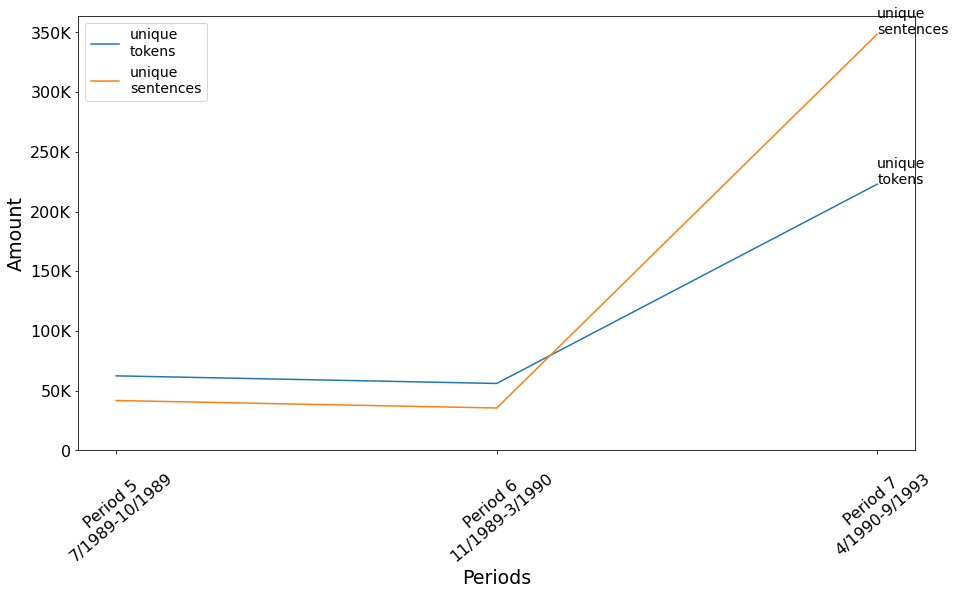

In [22]:
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(15, 8))
plt.ticklabel_format(style = 'plain')

periods = PERperiod_df_cleaned.period.to_list()

plt.plot(PERperiod_df_cleaned.period,PERperiod_df_cleaned.size_unique_tokens)
plt.annotate(text='unique\ntokens', xy=(periods[-1],PERperiod_df_cleaned.size_unique_tokens.to_list()[-1]), size=14)

# plt.plot(PERperiod_df_cleaned.period,PERperiod_df_cleaned.size_sent)
# plt.annotate(text='sentences', xy=(periods[-1],PERperiod_df_cleaned.size_sent.to_list()[-1]), size=14)

plt.plot(PERperiod_df_cleaned.period,PERperiod_df_cleaned.size_unique_sent)
plt.annotate(text='unique\nsentences', xy=(periods[-1],PERperiod_df_cleaned.size_unique_sent.to_list()[-1]), size=14)

x_labels = [periods_to_dates(period) for period in periods]    
plt.xticks(periods,x_labels, rotation=40)

ax = plt.gca()
formatter = FuncFormatter(numerize.numerize)
ax.yaxis.set_major_formatter(formatter)
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)
ax.legend(['unique\ntokens', 'unique\nsentences'], loc='upper left',prop={'size': 14})

plt.ylabel('Amount')
plt.xlabel('Periods')
plt.gca().set_ylim(bottom=0)
plt.rcParams['axes.labelsize'] = 19

### Common vocabulary size per period

In [23]:
# Sort periods based on number in the string
import re

def step_one_pairs(list_of_items):
    return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]

periods = sorted(PERperiod_df_cleaned.period.to_list())
period_pairs = step_one_pairs(periods)
print(period_pairs)

[(5, 6), (6, 7)]


In [24]:
PERperiod_df_cleaned['vocab'] = PERperiod_df_cleaned.speech.progress_apply(lambda x: nltk.word_tokenize(x))

100%|██████████| 3/3 [02:13<00:00, 44.64s/it]


In [25]:
common_vocab_cleaned = []

for pair in period_pairs:
    
    s1 = set(PERperiod_df_cleaned.loc[(PERperiod_df_cleaned.period==pair[0])].vocab.values[0])
    s2 = set(PERperiod_df_cleaned.loc[(PERperiod_df_cleaned.period==pair[1])].vocab.values[0])
    common_voc = len(s1.intersection(s2))
    common_vocab_cleaned.append([pair, common_voc])
    
common_vocab_cleaned = pd.DataFrame(common_vocab_cleaned, columns = ['pair', 'common_vocab'])
print(common_vocab_cleaned.head(2))

     pair  common_vocab
0  (5, 6)         27439
1  (6, 7)         41015


[5, 6, 7]
[(5, 6), (6, 7)]
[5.5, 6.5]


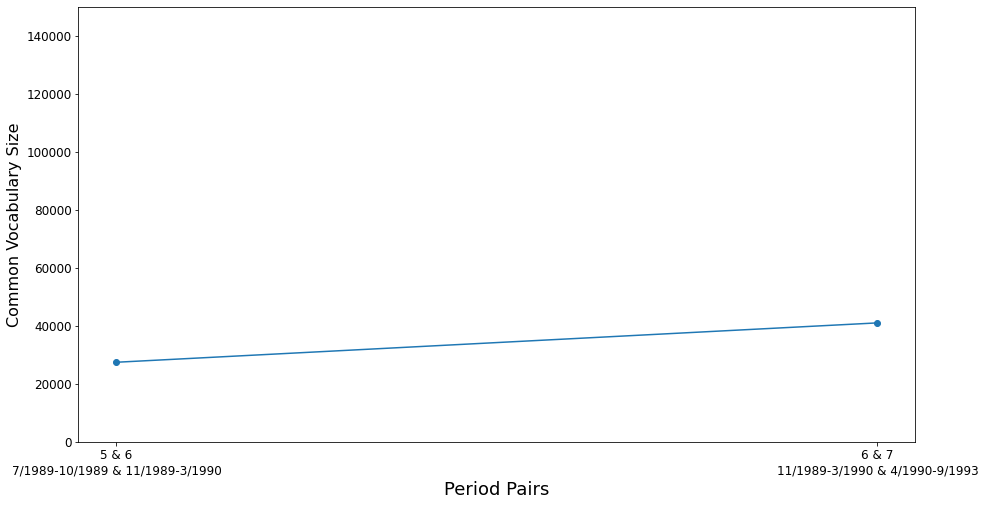

<Figure size 432x288 with 0 Axes>

In [26]:
from matplotlib.font_manager import FontProperties
import random
import matplotlib.pyplot as plt
import seaborn as sns

periods = sorted(PERperiod_df_cleaned.period.to_list())
print(periods)

period_pairs = step_one_pairs(periods)
print(period_pairs)

fig = plt.figure(figsize=(15, 8))
colors = sns.color_palette("hls", 90) #90 is available pairs

plt.rcParams.update({'font.size': 12})

X = common_vocab_cleaned.pair.to_list()
Y = common_vocab_cleaned.common_vocab.to_list()
X = [i+0.5 for i in range(periods[0], periods[-1])]
print(X)
plt.scatter(X,Y)

plt.plot(X,Y)
plt.xticks([i+0.5 for i in range(periods[0], periods[-1])], [
    (str(i)+' & '+str(i+1)+'\n'+periods_to_dates([i,i+1])) for i in range(periods[0], periods[-1])])

plt.xlabel('Period Pairs', fontsize=18)
plt.ylabel('Common Vocabulary Size', fontsize=16)

ax = plt.gca()
ax.set_ylim([0,150000])

handles, labels = ax.get_legend_handles_labels()
plt.savefig('../out_files/common_periodic_vocab_after_test.png', dpi=200,  bbox_inches='tight')

plt.show()
plt.cla()
plt.clf()
fig.clear()
plt.close(fig)


### Merged periods

In [27]:
df_merged_cleaned = pd.read_csv('../out_files/tell_all_cleaned.csv', nrows=200000) #, nrows=30000
df_merged_cleaned = df_merged_cleaned[df_merged_cleaned['speech'].notna()]

print(df_merged_cleaned.tail(2))

                           member_name sitting_date parliamentary_period  \
199998      βενιζελος κυριακου νικητας   03/02/1994             period 8   
199999  καστανιδης γεωργιου χαραλαμπος   03/02/1994             period 8   

       parliamentary_session parliamentary_sitting  \
199998             session 1            sitting 54   
199999             session 1            sitting 54   

                       political_party  \
199998                 πολιτικη ανοιξη   
199999  πανελληνιο σοσιαλιστικο κινημα   

                                          government    member_region  \
199998  ['παπανδρεου ανδρεα(13/10/1993-22/01/1996)']        α' αθηνων   
199999  ['παπανδρεου ανδρεα(13/10/1993-22/01/1996)']  α' θεσσαλονικης   

                                                   roles member_gender  \
199998  ['ε αντιπροεδρος βουλης(22/10/1993-10/08/1996)']          male   
199999                                     ['βουλευτης']          male   

       speaker_info                   

In [28]:
df_merged_cleaned = df_merged_cleaned.rename(columns={'parliamentary_period': 'period'})

df_merged_cleaned.period = df_merged_cleaned.period.apply(lambda x: x.replace(' review 9',''))
df_merged_cleaned.period = df_merged_cleaned.period.apply(lambda x: x.replace('period ',''))

df_merged_cleaned.period = df_merged_cleaned.period.astype(int)

df_merged_cleaned.loc[(df_merged_cleaned.period==5), 'period'] = 7
df_merged_cleaned.loc[(df_merged_cleaned.period==6), 'period'] = 7
df_merged_cleaned.loc[(df_merged_cleaned.period==14), 'period'] = 15
df_merged_cleaned.loc[(df_merged_cleaned.period==16), 'period'] = 17

print(datetime.datetime.now())
#Group speeches by year

PERperiod_df_merged_cleaned = df_merged_cleaned.groupby(df_merged_cleaned.period)['speech'].progress_apply('. '.join).reset_index() #concat sentences, each last sentence for each speech did not have dot so add one.

print(datetime.datetime.now())

  0%|          | 0/2 [00:00<?, ?it/s]

2021-06-22 03:13:34.887423


100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

2021-06-22 03:13:35.441112


In [29]:
PERperiod_df_merged_cleaned["size_chars"] = PERperiod_df_merged_cleaned.speech.progress_apply(len)
PERperiod_df_merged_cleaned["size_tokens"] = PERperiod_df_merged_cleaned.speech.progress_apply(lambda x: len(nltk.word_tokenize(x)))
PERperiod_df_merged_cleaned["size_unique_tokens"] = PERperiod_df_merged_cleaned.speech.progress_apply(lambda x: len(set(nltk.word_tokenize(x))))
PERperiod_df_merged_cleaned["size_sent"] = PERperiod_df_merged_cleaned.speech.progress_apply(lambda x: len(nltk.sent_tokenize(x)))
PERperiod_df_merged_cleaned["size_unique_sent"] = PERperiod_df_merged_cleaned.speech.progress_apply(lambda x: len(set(nltk.sent_tokenize(x))))


100%|██████████| 2/2 [00:53<00:00, 26.94s/it]


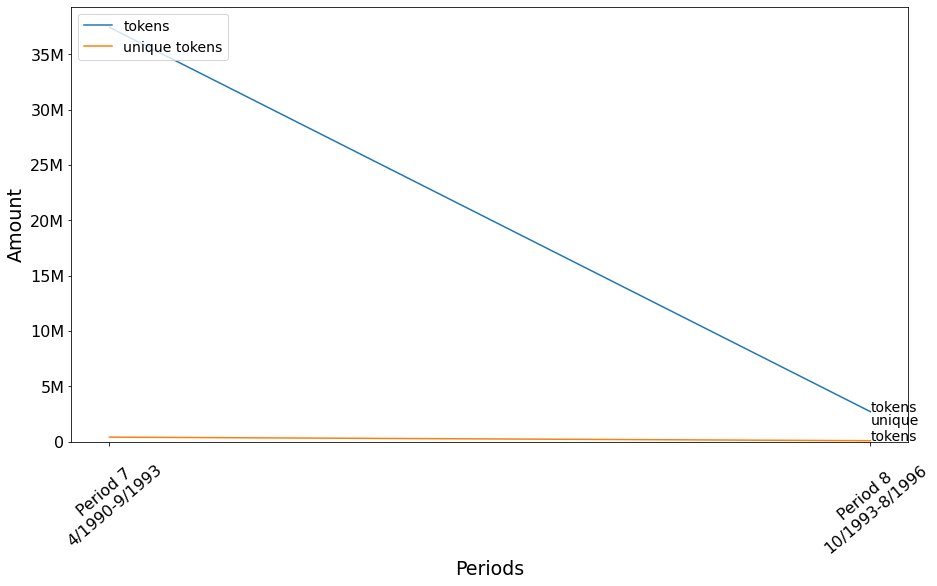

In [30]:
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(15, 8))
plt.ticklabel_format(style = 'plain')


periods = PERperiod_df_merged_cleaned.period.to_list()

# plt.plot(PERperiod_df_merged_cleaned.period,PERperiod_df_merged_cleaned.size_chars)
# plt.annotate(text='characters', xy=(periods[-1],PERperiod_df_merged_cleaned.size_chars.to_list()[-1]), size=14)

plt.plot(PERperiod_df_merged_cleaned.period,PERperiod_df_merged_cleaned.size_tokens)
plt.annotate(text='tokens', xy=(periods[-1],PERperiod_df_merged_cleaned.size_tokens.to_list()[-1]), size=14)

plt.plot(PERperiod_df_merged_cleaned.period,PERperiod_df_merged_cleaned.size_unique_tokens)
plt.annotate(text='unique\ntokens', xy=(periods[-1],PERperiod_df_merged_cleaned.size_unique_tokens.to_list()[-1]), size=14)

x_labels = [periods_to_dates(period) for period in periods]    
plt.xticks(periods,x_labels, rotation=40)

ax = plt.gca()
formatter = FuncFormatter(numerize.numerize)
ax.yaxis.set_major_formatter(formatter)
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)
ax.legend(['tokens', 'unique tokens'], loc='upper left',prop={'size': 14})

plt.ylabel('Amount')
plt.xlabel('Periods')
plt.gca().set_ylim(bottom=0)
plt.rcParams['axes.labelsize'] = 19

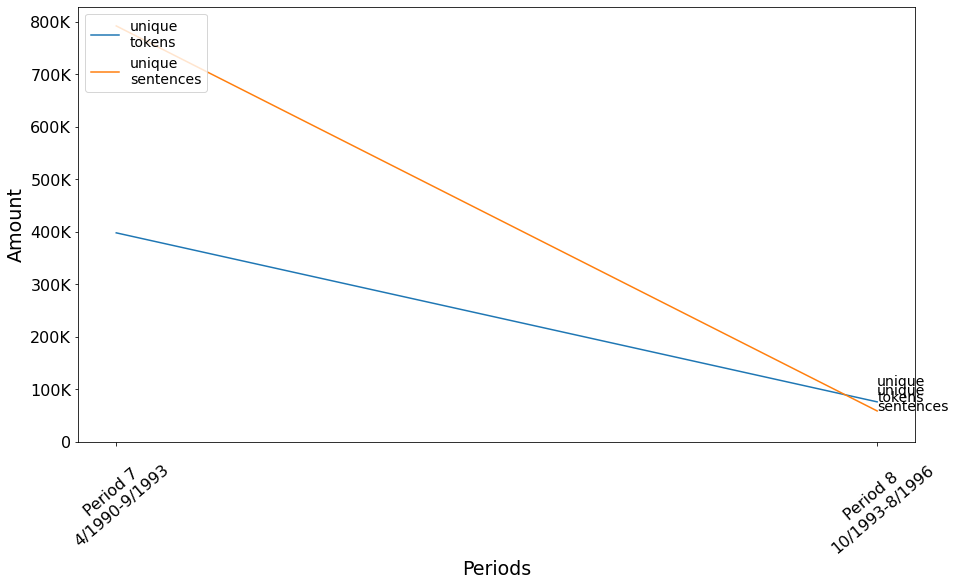

In [31]:
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(15, 8))
plt.ticklabel_format(style = 'plain')

periods = PERperiod_df_merged_cleaned.period.to_list()

plt.plot(PERperiod_df_merged_cleaned.period,PERperiod_df_merged_cleaned.size_unique_tokens)
plt.annotate(text='unique\ntokens', xy=(periods[-1],PERperiod_df_merged_cleaned.size_unique_tokens.to_list()[-1]), size=14)

# plt.plot(PERperiod_df_merged_cleaned.period,PERperiod_df_merged_cleaned.size_sent)
# plt.annotate(text='sentences', xy=(periods[-1],PERperiod_df_merged_cleaned.size_sent.to_list()[-1]), size=14)

plt.plot(PERperiod_df_merged_cleaned.period,PERperiod_df_merged_cleaned.size_unique_sent)
plt.annotate(text='unique\nsentences', xy=(periods[-1],PERperiod_df_merged_cleaned.size_unique_sent.to_list()[-1]), size=14)

x_labels = [periods_to_dates(period) for period in periods]    
plt.xticks(periods,x_labels, rotation=40)

ax = plt.gca()
formatter = FuncFormatter(numerize.numerize)
ax.yaxis.set_major_formatter(formatter)
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)
ax.legend(['unique\ntokens', 'unique\nsentences'], loc='upper left',prop={'size': 14})

plt.ylabel('Amount')
plt.xlabel('Periods')
plt.gca().set_ylim(bottom=0)
plt.rcParams['axes.labelsize'] = 19

### Common vocabulary size per period

In [32]:
# Sort periods based on number in the string
import re

def step_one_pairs(list_of_items):
    return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]

periods = sorted(PERperiod_df_merged_cleaned.period.to_list())
print(periods)

period_pairs = step_one_pairs(periods)
print(period_pairs)

[7, 8]
[(7, 8)]


In [33]:
PERperiod_df_merged_cleaned['vocab'] = PERperiod_df_merged_cleaned.speech.progress_apply(lambda x: nltk.word_tokenize(x))

100%|██████████| 2/2 [04:33<00:00, 136.68s/it]


In [34]:
common_vocab_merged_cleaned = []

for pair in period_pairs:
    
    s1 = set(PERperiod_df_merged_cleaned.loc[(PERperiod_df_merged_cleaned.period==pair[0])].vocab.values[0])
    s2 = set(PERperiod_df_merged_cleaned.loc[(PERperiod_df_merged_cleaned.period==pair[1])].vocab.values[0])
    common_voc = len(s1.intersection(s2))
    common_vocab_merged_cleaned.append([pair, common_voc])
    
common_vocab_df_merged_cleaned = pd.DataFrame(common_vocab_merged_cleaned, columns = ['pair', 'common_vocab'])
print(common_vocab_df_merged_cleaned.head(2))

     pair  common_vocab
0  (7, 8)         57247


In [35]:
print(periods)
print(period_pairs)

[7, 8]
[(7, 8)]


[7.5]
[57247]


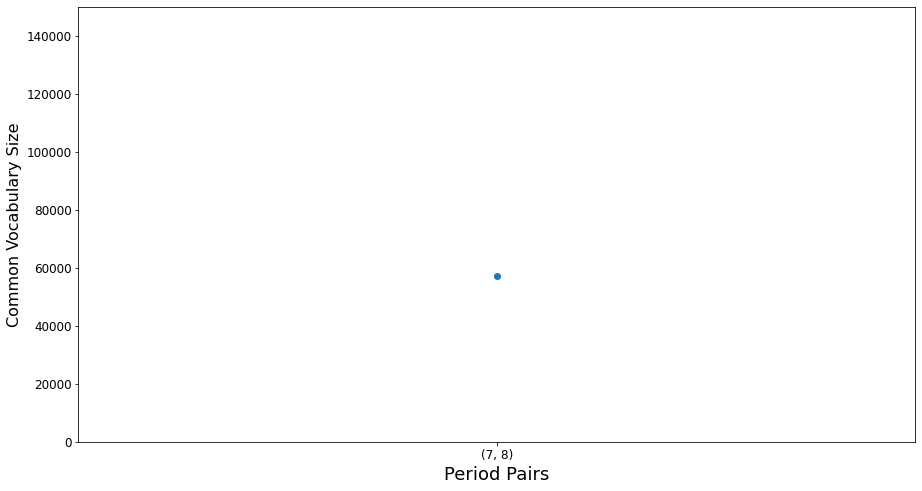

<Figure size 432x288 with 0 Axes>

In [36]:
from matplotlib.font_manager import FontProperties
import random
import matplotlib.pyplot as plt
import seaborn as sns


fig = plt.figure(figsize=(15, 8))
colors = sns.color_palette("hls", 90) #90 is available pairs

plt.rcParams.update({'font.size': 12})

# X = common_vocab_df_merged_cleaned.pair.to_list()
Y = common_vocab_df_merged_cleaned.common_vocab.to_list()
X = [(pair[0]+pair[1])/2 for pair in period_pairs]

print(X)
print(Y)
plt.scatter(X,Y)

plt.plot(X,Y)
plt.xticks(X, period_pairs)

plt.xlabel('Period Pairs', fontsize=18)
plt.ylabel('Common Vocabulary Size', fontsize=16)
# plt.gca().set_ylim(bottom=0)
# plt.gca().set_ylim([0,150000])
# plt.gca().set_ylim(bottom=0)150000
ax = plt.gca()
ax.set_ylim([0,150000])
handles, labels = ax.get_legend_handles_labels()
plt.savefig('../out_files/common_periodic_vocab_merged_after_test.png', dpi=200,  bbox_inches='tight')

plt.show()
plt.cla()
plt.clf()
fig.clear()
plt.close(fig)


In [37]:
import seaborn as sns
# print(PERperiod_df_original.columns)
# print(PERperiod_df_original.head(2))

metrics = ['size_chars', 'size_tokens', 'size_unique_tokens', 'size_sent', 'size_unique_sent']
# boxplot = PERperiod_df_original.boxplot(column=metrics)
# print(type(boxplot))

average_stats_original = []

avg_metrics = [numerize.numerize(PERperiod_df_original[metric].mean()) for metric in metrics]
average_stats_original.append(['before_preprocessing']+avg_metrics)

avg_metrics = [numerize.numerize(PERperiod_df_cleaned[metric].mean()) for metric in metrics]
average_stats_original.append(['after_preprocessing']+avg_metrics)

avg_metrics = [numerize.numerize(PERperiod_df_merged_cleaned[metric].mean()) for metric in metrics]
average_stats_original.append(['after_merging']+avg_metrics)

average_stats_df_original = pd.DataFrame(average_stats_original, columns = ['step'] + metrics)
print(average_stats_df_original)
average_stats_df_original.to_csv('../out_files/avg_stats.csv', index=False)

                   step size_chars size_tokens size_unique_tokens size_sent  \
0  before_preprocessing     27.54M        4.8M             108.8K   210.79K   
1   after_preprocessing     26.11M       6.62M            113.78K   148.91K   
2         after_merging     79.35M      20.07M            236.69K   450.99K   

  size_unique_sent  
0          191.23K  
1          141.92K  
2          425.23K  


# Older stats per year

### Common vocabulary size per year

In [38]:
# # in csv date is a string 03/07/1989 	set format="%d/%m/%Y" to convert to yy-mm-dd: 1989-07-03
# PERyear_df = df.copy()
# PERyear_df.sitting_date = pd.to_datetime(PERyear_df.sitting_date, format="%d/%m/%Y")
# PERyear_df['year'] = PERyear_df['sitting_date'].dt.year

# #Group speeches by year
# PERyear_df = PERyear_df.groupby(['year'])['speech'].apply(' '.join).reset_index()

# PERyear_df.speech = PERyear_df.speech.apply(
#     lambda x: nltk.word_tokenize(x.lower()))

# PERyear_df['vocab'] = PERyear_df.speech.apply(lambda x: list(set(x)))
# years = PERyear_df.year.to_list()
# years.sort()

# year_pairs = step_one_pairs(years)

In [39]:
# voc_list = []

# for pair in year_pairs:
#     s1 = set(PERyear_df.loc[(PERyear_df.year==pair[0])].vocab.values[0])
#     s2 = set(PERyear_df.loc[(PERyear_df.year==pair[1])].vocab.values[0])
#     common_voc = len(s1.intersection(s2))
#     voc_list.append([pair, common_voc])
    
# yearly_voc_df = pd.DataFrame(voc_list, columns = ['pair', 'common_vocab'])
# print(yearly_voc_df.head(2))

In [40]:
# from matplotlib.font_manager import FontProperties
# import random
# import matplotlib.pyplot as plt
# import seaborn as sns

# fig = plt.figure(figsize=(40, 10))
# colors = sns.color_palette("hls", 90) #90 is available pairs

# plt.rcParams.update({'font.size': 12})

# X = yearly_voc_df.pair.to_list()
# Y = yearly_voc_df.common_vocab.to_list()
# X = [i[0]+0.5 for i in year_pairs]
# print(X)
# plt.scatter(X,Y)

# plt.plot(X,Y)
# plt.xticks([i[0]+0.5 for i in year_pairs], yearly_voc_df.pair.to_list())

# plt.xlabel('Year Pairs', fontsize=18)
# plt.ylabel('Common Vocabulary Size', fontsize=16)

# ax = plt.gca()
# ax.set_ylim([0,150000])
# # ax.set_ylim([0,150000])

# handles, labels = ax.get_legend_handles_labels()
# plt.savefig('../out_files/common_yearly_vocab.png', dpi=200,  bbox_inches='tight')

# plt.show()
# plt.cla()
# plt.clf()
# fig.clear()
# plt.close(fig)

# #     break




### Vocabulary size per year per party

In [41]:
# PERyear_PERparty_df = df.copy()
# PERyear_PERparty_df.sitting_date = pd.to_datetime(PERyear_PERparty_df.sitting_date, format="%d/%m/%Y")
# PERyear_PERparty_df['year'] = PERyear_PERparty_df['sitting_date'].dt.year

# #Group speeches by year
# PERyear_PERparty_df = PERyear_PERparty_df.groupby(['year', 'political_party'])['speech'].apply(' '.join).reset_index()

# PERyear_PERparty_df.speech = PERyear_PERparty_df.speech.apply(
#     lambda x: nltk.word_tokenize(x.lower()))

# PERyear_PERparty_df['vocab'] = PERyear_PERparty_df.speech.apply(lambda x: list(set(x)))



In [42]:
# years = list(set(PERyear_PERparty_df.year.to_list()))
# years.sort()
# year_pairs = step_one_pairs(years)
# parties = list(set(PERyear_PERparty_df.political_party.to_list()))

# voc_list = []
# for party in parties:
#     for pair in year_pairs:
        
#         if (party in PERyear_PERparty_df.loc[(PERyear_PERparty_df.year==pair[0])].political_party.to_list()
#            ) and (party in PERyear_PERparty_df.loc[(PERyear_PERparty_df.year==pair[1])].political_party.to_list()): 
           
        
#             s1 = set(PERyear_PERparty_df.loc[(PERyear_PERparty_df.year==pair[0]
#                                                  ) & (PERyear_PERparty_df.political_party==party
#                                                      )].vocab.values[0])

#             s2 = set(PERyear_PERparty_df.loc[(PERyear_PERparty_df.year==pair[1]
#                                              ) & (PERyear_PERparty_df.political_party==party
#                                                  )].vocab.values[0])
#         common_voc = len(s1.intersection(s2))
#         voc_list.append([party, pair, common_voc])

# year_party_voc_df = pd.DataFrame(voc_list, columns = ['party','pair', 'common_vocab'])
# print(year_party_voc_df.head(2))

In [43]:

# fig = plt.figure(figsize=(40, 10))
# colors = sns.color_palette("hls", 90) #90 is available pairs
# plt.rcParams.update({'font.size': 12})


# for party in parties:

#     X = year_party_voc_df.loc[year_party_voc_df.party==party].pair.to_list()
#     Y = year_party_voc_df.loc[year_party_voc_df.party==party].common_vocab.to_list()
#     X = [i[0]+0.5 for i in year_pairs]
# #     print(X)
#     plt.scatter(X,Y)

#     plt.plot(X,Y, label=party)
#     plt.xticks([i[0]+0.5 for i in year_pairs], yearly_voc_df.pair.to_list())

# plt.xlabel('Year Pairs', fontsize=18)
# plt.ylabel('Common Vocabulary Size', fontsize=16)

# ax = plt.gca()
# handles, labels = ax.get_legend_handles_labels()
# plt.savefig('../out_files/common_year_party_vocab.png', dpi=200,  bbox_inches='tight')

# plt.show()
# plt.cla()
# plt.clf()
# fig.clear()
# plt.close(fig)
